In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
# from math import comb
import pymc3 as pm
import arviz as az

# Problem 1

In [14]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    # sample n times 
    sample = np.random.binomial(n, p)
    
    # uniform prior
    prior = 1

    # grid of points
    num_points = 51
    thetas = np.linspace(0, 1, num_points)
    f_x_p = thetas**(sample) * (1-thetas)**(n-sample)

    denom = np.sum(thetas**(sample) * (1-thetas)**(n-sample))
    posterior = f_x_p*prior/denom

    # plot
    
    plt.plot(thetas, posterior)
    plt.xlabel("Values for p")
    plt.ylabel("Likelihood")
    plt.title("Bernoulli Sampling to find MAP")
    plt.show()

    return thetas[np.argmax(posterior)]

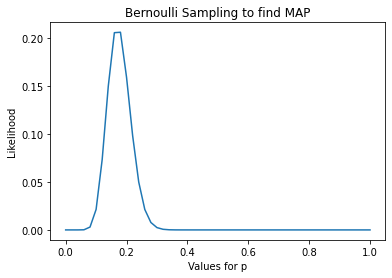

MAP p: 0.18


In [29]:
print("MAP p:", bernoulli_sampling(p=0.2, n=100))

# Problem 2

In [30]:
def non_uniform_prior(p, n, prior=beta(5, 1.5)):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    # sample n times 
    sample = np.random.binomial(n, p)

    # grid of points
    num_points = 51
    thetas = np.linspace(0, 1, num_points)
    f_x_p_with_prior = thetas**(sample) * (1-thetas)**(n-sample) * prior.pdf(thetas)

    denom = np.sum(thetas**(sample) * (1-thetas)**(n-sample) * prior.pdf(thetas))
    posterior = f_x_p_with_prior/denom

    # plot
    
    plt.plot(thetas, posterior)
    plt.xlabel("Values for p")
    plt.ylabel("Likelihood")
    plt.title("Non Uniform Sampling to find MAP")
    plt.show()

    return thetas[np.argmax(posterior)]


True p: 0.4


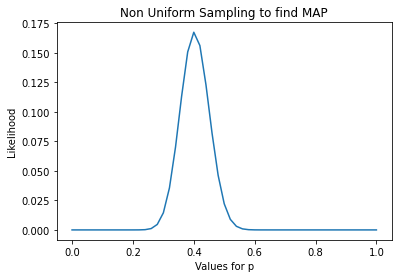

MAP p with : 0.4

True p: 0.9


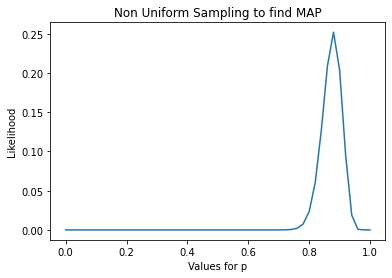

MAP p with : 0.88


In [33]:
print("True p:", 0.4)
print("MAP p with :", non_uniform_prior(p=0.4, n=100, prior=beta(5,1.5)))
print("")
print("True p:", 0.9)
print("MAP p with :", non_uniform_prior(p=0.9, n=100, prior=beta(5,1.5)))


Note that the posterior likelihood where the MAP was 0.9 is skinnier than the likelihood graph when the MAP was 0.4. This tells us that the variance is lower and there is a higher confidence that 0.9 is correct, than in the case where 0.4 was the output. We are more confident in estimating the bias when the coin gives heads 90% of the time.

# Problem 3

In [44]:
def weather_forecast(markov, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    # store weather variables
    weather = {0:"sun", 1:"rain", 2:"wind"}

    current = 0
    forecast = []
    # loop through and find next day
    for i in range(days):
        # print(markov[current])
        current = np.random.choice([0,1,2], p=markov[current])
        forecast.append(weather[current])
    
    return forecast

In [45]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)
weather_forecast(transition_matrix, days=10)

['sun', 'sun', 'sun', 'wind', 'rain', 'rain', 'sun', 'sun', 'wind', 'rain']

# Problem 4

In [18]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    # run PyMC3 model
    model = pm.Model()
    with model:
        p = pm.Beta('p', alpha=1, beta=1) 
        y = pm.Bernoulli('y', p=p, observed=data)
        trace = pm.sample(n) #n is the desired number of samples
        az.plot_trace(trace)
        p = trace['p']
        mean = p.mean()
        plt.plot() # print trace plot
        return mean
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8818326912963645, but should be close to 0.8. Try to increase the number of tuning steps.


0.25070108227767196


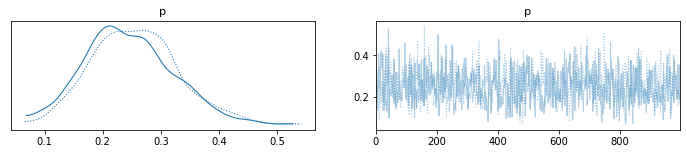

In [19]:
data = bernoulli.rvs(0.2, size=30)
print(posterior_sampling(data, n=1000))

# Problem 5

In [22]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    # run PyMC3 model
    model = pm.Model()
    with model:
        # Set up variables with distributions
        mu = pm.Normal('mu', mu=m, sigma=s)
        tau=pm.Gamma('tau', alpha=alpha,beta=beta)
        y = pm.Normal('y', mu=mu, tau=tau, observed=observed_heights)

        # Trace plot
        trace = pm.sample(n) #n is the desired number of samples
        az.plot_trace(trace)
        p = trace['mu']
        mean = p.mean()
        plt.plot() # print trace plot
        
        return mean

In [25]:
heights = np.random.normal(178,10,100)
print("Mean mu:", height_model(heights, m=180,s=10,alpha=2,beta=10,n=100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, mu]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 2 seconds.


Mean mu: 177.26828538272875
